In [1]:
library(ggplot2)
library(dplyr)
library(gplots)
library(reshape2)
library(umap)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)
library(heatmap.plus)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessage

In [57]:
raw<-read.table(file="./Bioskryb_DNA_final_summary.txt",header=T)
variant_anno<-read.csv(file="../../variant_annotation/780_variant_annotation_by_all_samples.csv",header=T)

In [58]:
unique(raw$Mosaic_shared_btw_WGS_Amp)

[1] 1 0

In [59]:
raw$BINARY[raw$NORMAL_UPPER_CI>raw$LOWER_CI]<-0
raw$BINARY[raw$NORMAL_UPPER_CI<raw$LOWER_CI]<-1

In [60]:
length(((raw[raw$BINARY==1,]$CHROM.POS.REF.ALT)))

[1] 53919

In [68]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered2 <- subset(raw, BINARY %in% c(1) &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1 
                                                       # (variant_anno$R==1 & variant_anno$IN_only==1) | (variant_anno$R==1 & variant_anno$CTX_BG_shared==1)
                                                       # (variant_anno$Right_only==1 & variant_anno$T==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$F==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_BG_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_HIP_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP_BG_shard==1) 
                                                       ,]$variant_list &
                   Cell_Type %in% c("ExN","InN") & PLATE %in% c("PL01","PL02"))

# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered2$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered2$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered2$CHROM.POS.REF.ALT)
for (i in unique(filtered2$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered2, CHROM.POS.REF.ALT==i))
}

# filter out high AF MVs
filtered2<-subset(filtered2, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>1,]$variant)

In [69]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered <- subset(raw, SAMPLE %in% filtered2$SAMPLE &
                   CHROM.POS.REF.ALT %in% filtered2$CHROM.POS.REF.ALT &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   #CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1,]$variant_list &
                   Cell_Type %in% c("ExN","InN") & PLATE %in% c("PL01","PL02"))

In [70]:
# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered$CHROM.POS.REF.ALT)
for (i in unique(filtered$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered, CHROM.POS.REF.ALT==i &  BINARY==1))
}

In [71]:
# filter out high AF MVs
filtered<-subset(filtered, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>1,]$variant)

In [72]:
#description of filtered data frame 
print(paste("number of variants:", length(unique(filtered$CHROM.POS.REF.ALT))))
print(paste("number of cells:", length(unique(filtered$SAMPLE))))
print(paste("number of Excitatory neurons:", length(unique(filtered[filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of Inhibitory neurons:", length(unique(filtered[filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of cells in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01",]$SAMPLE))))
print(paste("number of cells in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02",]$SAMPLE))))
print(paste("number of cells in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03",]$SAMPLE))))
print(paste("number of ExN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of InN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="InN",]$SAMPLE))))

[1] "number of variants: 68"
[1] "number of cells: 118"
[1] "number of Excitatory neurons: 85"
[1] "number of Inhibitory neurons: 33"
[1] "number of cells in Frontal lobe: 56"
[1] "number of cells in Temporal lobe: 62"
[1] "number of cells in Hippocampus: 0"
[1] "number of ExN in Frontal lobe: 40"
[1] "number of ExN in Temporal lobe: 45"
[1] "number of ExN in Hippocampus: 0"
[1] "number of InN in Frontal lobe: 16"
[1] "number of InN in Temporal lobe: 17"
[1] "number of InN in Hippocampus: 0"


In [73]:
shared_mosaic_filtered<-filtered
shared_mosaic_filtered$ID<-paste0(shared_mosaic_filtered$PLATE,shared_mosaic_filtered$SAMPLE)
melt_mtcars<-shared_mosaic_filtered[,c("BINARY","ID","PLATE","SAMPLE", "CHROM.POS.REF.ALT","Cell_Type")]
melt_mtcars<-na.omit(melt_mtcars)
melt_mtcars$BINARY <- sqrt(melt_mtcars$BINARY)
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+PLATE+SAMPLE+Cell_Type~CHROM.POS.REF.ALT, value.var = "BINARY",na.rm=T)
rownames(casted_MAF_VarBySample)<-casted_MAF_VarBySample$ID

In [74]:
casted_MAF_VarBySample2<-casted_MAF_VarBySample[,-1:-4]
label<-casted_MAF_VarBySample[,1:4]
casted_MAF_VarBySample2<-casted_MAF_VarBySample2[ , colSums(is.na(casted_MAF_VarBySample2)) == 0]
UMAP<-umap(casted_MAF_VarBySample2)
df<-as.data.frame(UMAP$layout)
df<-cbind(df,label)

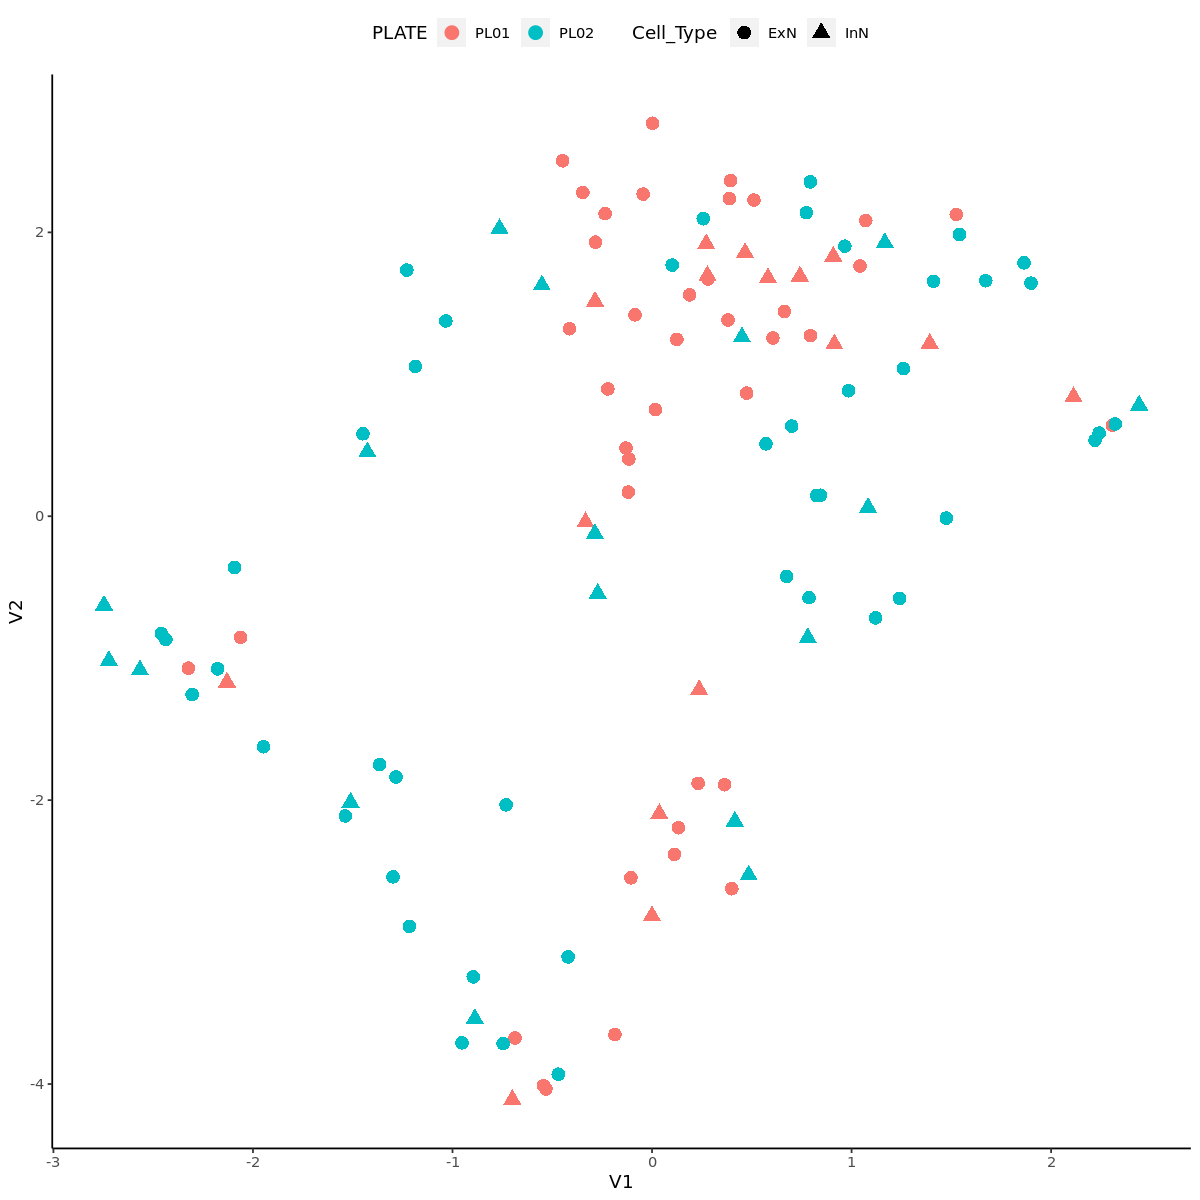

In [75]:
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=10)
p1<-ggplot(df, aes(x = V1, y = V2))+ 
geom_point(
    aes(color =PLATE , shape = Cell_Type),
    size = 3.5, 
    alpha = 1 # It's nice to add some transparency because there may be overlap.
  )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),legend.position = "top")
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=10)
p1

In [76]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered2 <- subset(raw, BINARY %in% c(1) &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1 
                                                       # (variant_anno$R==1 & variant_anno$IN_only==1) | (variant_anno$R==1 & variant_anno$CTX_BG_shared==1)
                                                       # (variant_anno$Right_only==1 & variant_anno$T==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$F==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_BG_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_HIP_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP_BG_shard==1) 
                                                       ,]$variant_list &
                   Cell_Type %in% c("ExN","InN") & PLATE %in% c("PL01","PL02","PL03"))

# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered2$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered2$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered2$CHROM.POS.REF.ALT)
for (i in unique(filtered2$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered2, CHROM.POS.REF.ALT==i))
}

# filter out high AF MVs
filtered2<-subset(filtered2, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>1,]$variant)

In [77]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered <- subset(raw, SAMPLE %in% filtered2$SAMPLE &
                   CHROM.POS.REF.ALT %in% filtered2$CHROM.POS.REF.ALT &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   #CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1,]$variant_list &
                   Cell_Type %in% c("ExN","InN") & PLATE %in% c("PL01","PL02","PL03"))

In [78]:
# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered$CHROM.POS.REF.ALT)
for (i in unique(filtered$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered, CHROM.POS.REF.ALT==i &  BINARY==1))
}

In [79]:
# filter out high AF MVs
filtered<-subset(filtered, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>1,]$variant)

In [80]:
#description of filtered data frame 
print(paste("number of variants:", length(unique(filtered$CHROM.POS.REF.ALT))))
print(paste("number of cells:", length(unique(filtered$SAMPLE))))
print(paste("number of Excitatory neurons:", length(unique(filtered[filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of Inhibitory neurons:", length(unique(filtered[filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of cells in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01",]$SAMPLE))))
print(paste("number of cells in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02",]$SAMPLE))))
print(paste("number of cells in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03",]$SAMPLE))))
print(paste("number of ExN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of InN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="InN",]$SAMPLE))))

[1] "number of variants: 72"
[1] "number of cells: 140"
[1] "number of Excitatory neurons: 95"
[1] "number of Inhibitory neurons: 45"
[1] "number of cells in Frontal lobe: 52"
[1] "number of cells in Temporal lobe: 62"
[1] "number of cells in Hippocampus: 26"
[1] "number of ExN in Frontal lobe: 39"
[1] "number of ExN in Temporal lobe: 46"
[1] "number of ExN in Hippocampus: 10"
[1] "number of InN in Frontal lobe: 13"
[1] "number of InN in Temporal lobe: 16"
[1] "number of InN in Hippocampus: 16"


In [81]:
shared_mosaic_filtered<-filtered
shared_mosaic_filtered$ID<-paste0(shared_mosaic_filtered$PLATE,shared_mosaic_filtered$SAMPLE)
melt_mtcars<-shared_mosaic_filtered[,c("BINARY","ID","PLATE","SAMPLE", "CHROM.POS.REF.ALT","Cell_Type")]
melt_mtcars<-na.omit(melt_mtcars)
melt_mtcars$BINARY <- sqrt(melt_mtcars$BINARY)
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+PLATE+SAMPLE+Cell_Type~CHROM.POS.REF.ALT, value.var = "BINARY",na.rm=T)
rownames(casted_MAF_VarBySample)<-casted_MAF_VarBySample$ID

In [82]:
casted_MAF_VarBySample2<-casted_MAF_VarBySample[,-1:-4]
label<-casted_MAF_VarBySample[,1:4]
casted_MAF_VarBySample2<-casted_MAF_VarBySample2[ , colSums(is.na(casted_MAF_VarBySample2)) == 0]
UMAP<-umap(casted_MAF_VarBySample2)
df<-as.data.frame(UMAP$layout)
df<-cbind(df,label)

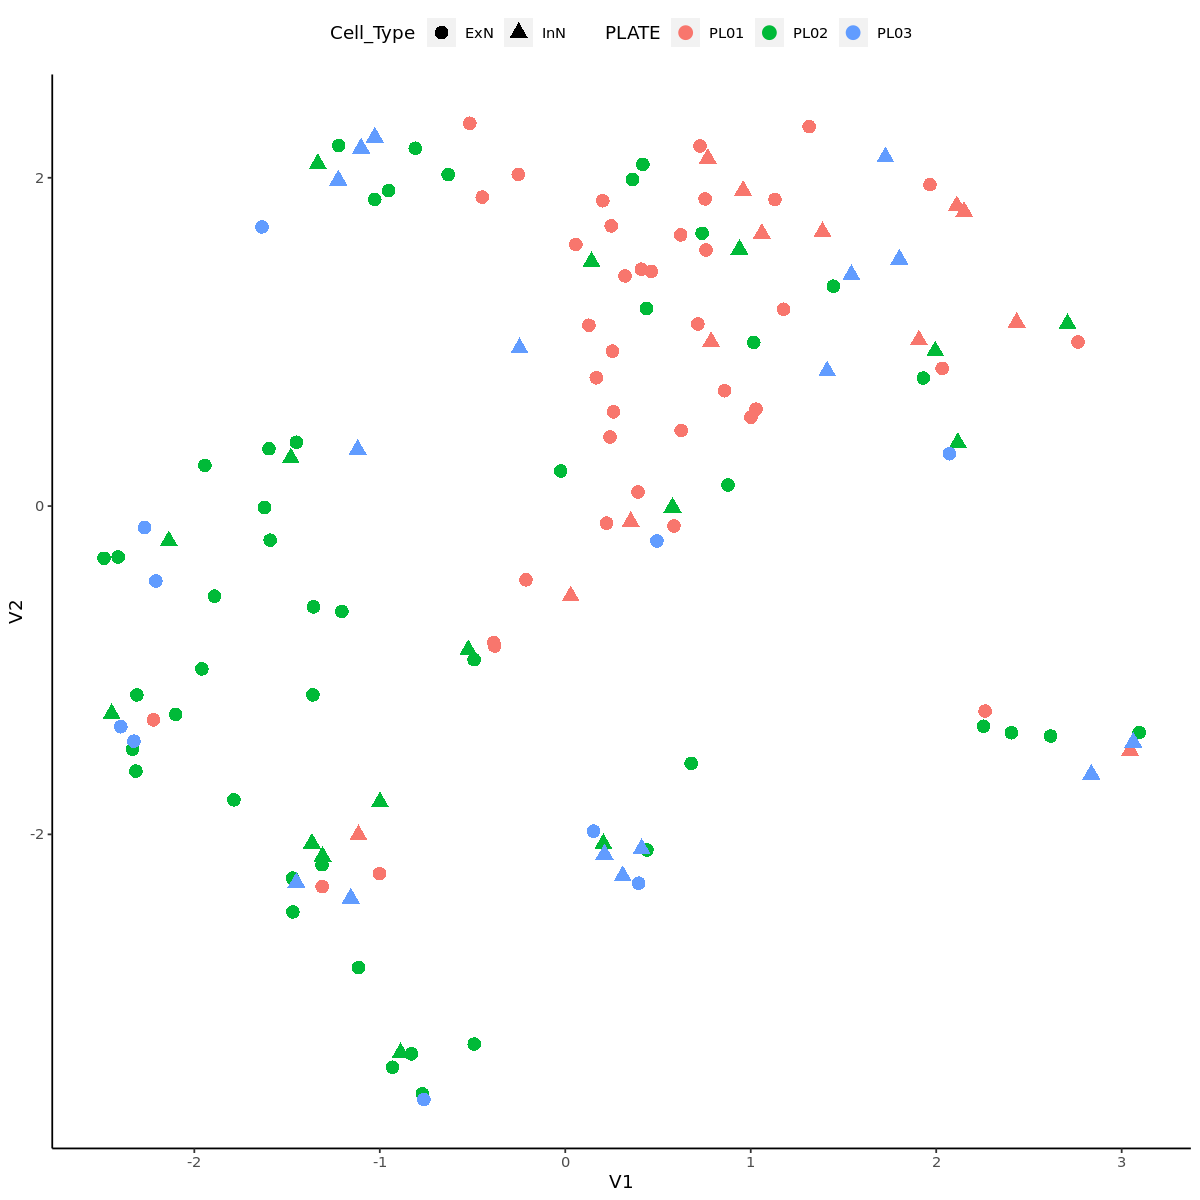

In [83]:
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=10)
p1<-ggplot(df, aes(x = V1, y = V2))+ 
geom_point(
    aes(color =PLATE , shape = Cell_Type),
    size = 3.5, 
    alpha = 1 # It's nice to add some transparency because there may be overlap.
  )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),legend.position = "top")
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=10)
p1